# Data Acquisition
<p>In Excel, combined relevant/similar columns from 2007, 2009, 2011, 2013, 2015-2019 LAHSA Homeless Counts, available from <a href="https://www.lahsa.org/documents">LAHSA</a> and <a href="https://economicrt.org/publication/los-angeles-county-homeless-count-data-library/">Economic Roundtable</a>. Also extracted LA evictions data for 2000-2016 from the <a href="https://evictionlab.org/">Princeton Eviction Lab.</a></p>
<p>Read in homeless count and evictions data as pandas dataframes called homelessness and evictions.</p>

In [1]:
import os
import pandas as pd
import numpy as np



In [108]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 8]

import seaborn as sns
sns.set()

In [ ]:
#import LA homelessness data & LA evictions data
homelessness = pd.read_excel('/Users/sgd/Dropbox/Documents/DataIncubator/CapstoneProject/HomelessCountData/homelessnessdata2007-2019.xlsx', header=0)
evictions = pd.read_excel('/Users/sgd/Dropbox/Documents/DataIncubator/CapstoneProject/EvictionsData/LACEvictionsByTract.xlsx', header=0)

In [2]:
#check dataframes
homelessness.head()
#print(evictions.head())
#print(homelessness.head())

print([col for col in homelessness])
print([col for col in evictions])
#evictions.loc[[0],['GEOID']]
evictions['GEOID'].head()

['Year', 'tractNum', 'totalUnshelteredPeopleCount', 'adultsCount', 'youthCount', 'totalFamiliesCount', 'carsCount', 'vansCount', 'campersCount', 'tentsCount', 'otherShelterCount']
['GEOID', 'year', 'name', 'parent-location', 'population', 'poverty-rate', 'renter-occupied-households', 'pct-renter-occupied', 'median-gross-rent', 'median-household-income', 'median-property-value', 'rent-burden', 'pct-white', 'pct-af-am', 'pct-hispanic', 'pct-am-ind', 'pct-asian', 'pct-nh-pi', 'pct-multiple', 'pct-other', 'eviction-filings', 'evictions', 'eviction-rate', 'eviction-filing-rate', 'low-flag', 'imputed', 'subbed']


0    6037101110
1    6037101110
2    6037101110
3    6037101110
4    6037101110
Name: GEOID, dtype: int64

# Data Reorganization and Combination
<p>Create a new sorting column for evictions data because census tracts are in long form with state and county. To match Homelessness data, they should be in short form with only the rightmost 6 digits.</p>
<p>Then, combine dataframes on both a year and tract match.</p>

In [43]:
# make a new column called NEW_TRACT that contains only the last 6 digits of the original GEOID column
evictions['NEW_TRACT'] = evictions['GEOID']%1000000

#merge homelessness and evictions dataframes on year and tract number (outer merge)
evictionsandhomelessness = pd.merge(homelessness, evictions,  how='outer', left_on=['Year','tractNum'], right_on = ['year','NEW_TRACT'])

print(evictions.shape) #(39888, 28)
print(homelessness.shape) #(15231, 11)
print(evictionsandhomelessness.shape)
print(evictionsandhomelessness.head())
evictionsandhomelessness.loc[6000] # this is tract 240200, may be a good one to plot

#drop unnecessary rows from joined dataframe
cleanedEandHdata = evictionsandhomelessness.drop(['name', 'parent-location', 'low-flag', 'pct-white', 'pct-af-am', 'pct-hispanic', 'pct-am-ind', 'pct-asian', 'pct-nh-pi', 'pct-multiple', 'pct-other', 'imputed', 'subbed'], axis=1)
cleanedEandHdata.shape # (47544, 26)


(39888, 28)
(15231, 11)
(47544, 39)
     Year  tractNum  totalUnshelteredPeopleCount  adultsCount  youthCount  \
0  2007.0  101110.0                          0.0          NaN         0.0   
1  2013.0  101110.0                          4.0          4.0         0.0   
2  2015.0  101110.0                          0.0          0.0         0.0   
3  2016.0  101110.0                          6.0          4.0         NaN   
4  2017.0  101110.0                          1.0          1.0         1.0   

   totalFamiliesCount  carsCount  vansCount  campersCount  tentsCount  \
0                 NaN        NaN        NaN           NaN         NaN   
1                 0.0        0.0        1.0           0.0         0.0   
2                 0.0        0.0        0.0           0.0         0.0   
3                 0.0        0.0        0.0           0.0         0.0   
4                 0.0        0.0        0.0           0.0         0.0   

     ...      pct-multiple  pct-other  eviction-filings  evict

(47544, 26)

# Make a few sample plots to get a handle on the data

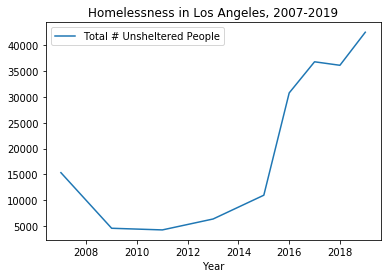

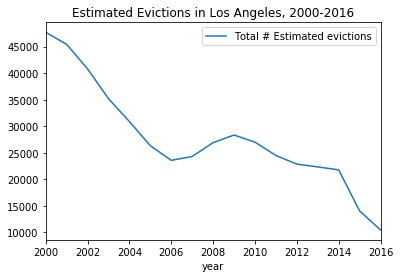

In [44]:
#Total Unsheltered People by year plot
homelessnessbyyear = cleanedEandHdata.groupby(['Year'])[["totalUnshelteredPeopleCount"]].sum()
type(cleanedEandHdata)
lines = homelessnessbyyear.plot.line(title='Homelessness in Los Angeles, 2007-2019')
lines.legend(["Total # Unsheltered People"])

#Total estimated evictions by year plot
evictionsbyyear = cleanedEandHdata.groupby(['year'])[["evictions"]].sum()
evline = evictionsbyyear.plot.line(title='Estimated Evictions in Los Angeles, 2000-2016', xlim=(2000,2016))
evline.legend(['Total # Estimated evictions'])

Text(0.5, 1.0, 'Example plot of Homelessness and Evictions, 2007 - 2016 in Tract #240200')

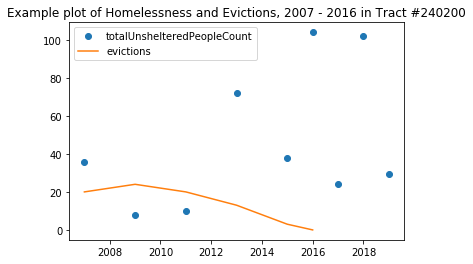

In [45]:
#Example plot of Evictions vs. homelessness by year in a single census tract
tract240200 = cleanedEandHdata.loc[cleanedEandHdata['tractNum'] == 240200]
tract240200.head()
plt.plot(tract240200['Year'], tract240200['totalUnshelteredPeopleCount'],'o')
plt.plot(tract240200['Year'], tract240200['evictions'],'-')
plt.legend()
plt.title("Example plot of Homelessness and Evictions, 2007 - 2016 in Tract #240200")

In [47]:
cleanedEandHdata['povrategroup'] = pd.cut(cleanedEandHdata['poverty-rate'],bins=[0,25,50,75,100], labels=[1,2,3,4])
EH_narm = cleanedEandHdata.dropna(subset=['povrategroup','evictions','totalUnshelteredPeopleCount'])
print(EH_narm.shape)
EH_narm.columns
EH_narm['povrategroup'].describe()
EH_narm.count()
EH_narm[0:50]
EH_narm.sort_values(by=['tractNum', 'Year'])
#EH_narm['totalUnshelteredPeopleCount'] = pd.to_numeric(EH_narm['totalUnshelteredPeopleCount'])

(7332, 27)


,Year,tractNum,totalUnshelteredPeopleCount,adultsCount,youthCount,totalFamiliesCount,carsCount,vansCount,campersCount,tentsCount,...,median-gross-rent,median-household-income,median-property-value,rent-burden,eviction-filings,evictions,eviction-rate,eviction-filing-rate,NEW_TRACT,povrategroup
0,2007.0,101110.0,0.000000,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,1072.00,55729.00,437700.00,33.70,11.0,8.0,1.04,1.43,101110.0,1
1,2013.0,101110.0,4.000000,4.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1336.00,50694.00,372800.00,38.80,6.0,5.0,0.64,0.77,101110.0,1
2,2015.0,101110.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1336.00,50694.00,372800.00,38.80,7.0,5.0,0.63,0.88,101110.0,1
3,2016.0,101110.0,6.000000,4.0,NaN,0.0,0.0,0.0,0.0,0.0,...,1336.00,50694.00,372800.00,38.80,5.0,5.0,0.62,0.62,101110.0,1
13,2007.0,101210.0,0.000000,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,1044.00,43115.00,456100.00,35.70,42.0,36.0,2.00,2.34,101210.0,1
14,2013.0,101210.0,9.000000,9.0,0.0,0.0,0.0,2.0,9.0,0.0,...,1120.00,39502.00,318200.00,32.70,24.0,16.0,0.88,1.31,101210.0,1
15,2015.0,101210.0,6.000000,6.0,0.0,0.0,0.0,0.0,2.0,1.0,...,1120.00,39502.00,318200.00,32.70,25.0,23.0,1.24,1.35,101210.0,1
16,2016.0,101210.0,19.000000,9.0,NaN,0.0,1.0,0.0,4.0,0.0,...,1120.00,39502.00,318200.00,32.70,17.0,15.0,0.80,0.91,101210.0,1
20,2007.0,101220.0,2.000000,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,900.00,50635.00,429400.00,28.30,8.0,8.0,1.04,1.04,101220.0,1
21,2013.0,101220.0,2.000000,2.0,0.0,0.0,0.0,0.0,2.0,0.0,...,1087.00,41129.00,370200.00,38.90,11.0,9.0,1.15,1.40,101220.0,1


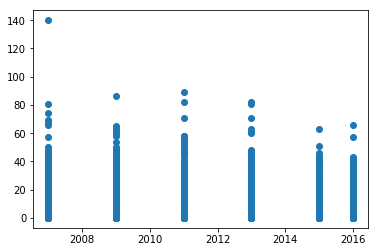

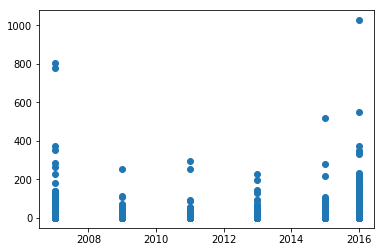

In [99]:
plt.plot(EH_narm['Year'], EH_narm['evictions'],'o')
plt.show()
plt.plot(EH_narm['Year'], EH_narm['totalUnshelteredPeopleCount'],'o')
plt.show()

## Plot Data by poverty percentage group
<p>Group 1 = 25% or less poverty rate</p>
<p>Group 2 = 25-50% poverty rate</p>
<p>Group 3 = 50-75% poverty rate</p>
<p>Group 4 = >75% poverty rate</p>

In [197]:
lowpov = EH_narm[EH_narm['povrategroup'] == 1] #slice data frame to include rows with only by pov group 1 shape: (5758, 27)
medlowpov = EH_narm[EH_narm['povrategroup'] == 2] #shape: (1487, 27)
medhighpov = EH_narm[EH_narm['povrategroup'] == 3] #shape: (73, 27)
highpov = EH_narm[EH_narm['povrategroup'] == 4] #shape: (14, 27)
highpov.shape

(14, 29)

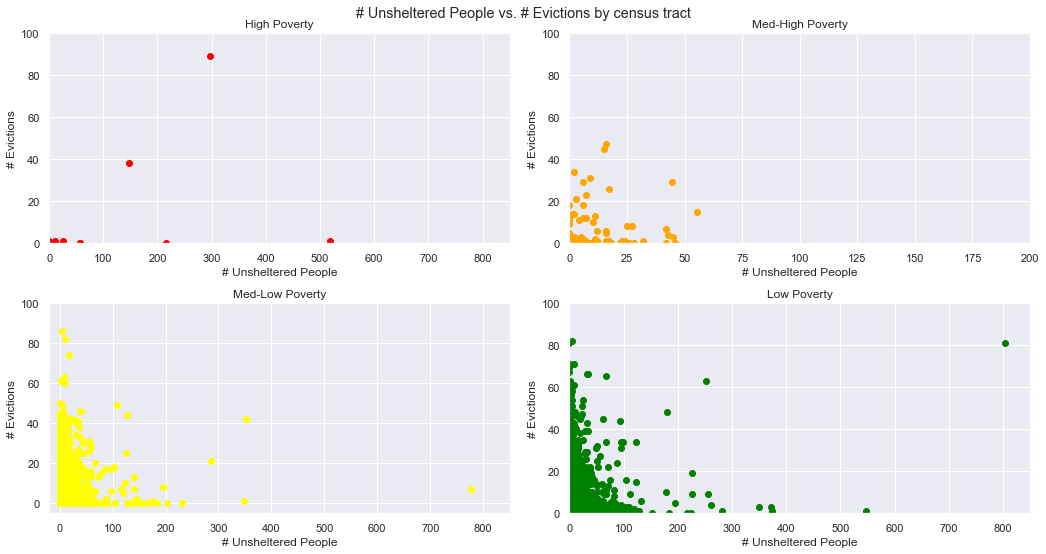

In [154]:
plt.subplot(2, 2, 1)
plt.title('High Poverty')
plt.xlabel('# Unsheltered People')
plt.ylabel('# Evictions')
plt.xlim(0,850)
plt.ylim(0,100)
highplot = plt.plot(highpov['totalUnshelteredPeopleCount'], highpov['evictions'],'o', color='red')

plt.subplot(2,2,2)
plt.title('Med-High Poverty')
plt.xlabel('# Unsheltered People')
plt.ylabel('# Evictions')
plt.xlim(0,200)
plt.ylim(0,100)
medhighplot = plt.plot(medhighpov['totalUnshelteredPeopleCount'], medhighpov['evictions'],'o', color='orange')

plt.subplot(2,2,3)
plt.title('Med-Low Poverty')
plt.xlabel('# Unsheltered People')
plt.ylabel('# Evictions')
plt.xlim(-20,850)
plt.ylim(-5,100)
medlowplot = plt.plot(medlowpov['totalUnshelteredPeopleCount'], medlowpov['evictions'],'o', color='yellow')

plt.subplot(2,2,4)
plt.title('Low Poverty')
plt.xlabel('# Unsheltered People')
plt.ylabel('# Evictions')
plt.xlim(0,850)
plt.ylim(0,100)
lowplot = plt.plot(lowpov['totalUnshelteredPeopleCount'], lowpov['evictions'],'o', color='green')

plt.suptitle('# Unsheltered People vs. # Evictions by census tract')
plt.tight_layout(pad=2.0, w_pad=1.0, h_pad=1.0)

## Plot Data by Year and Poverty Rate Group

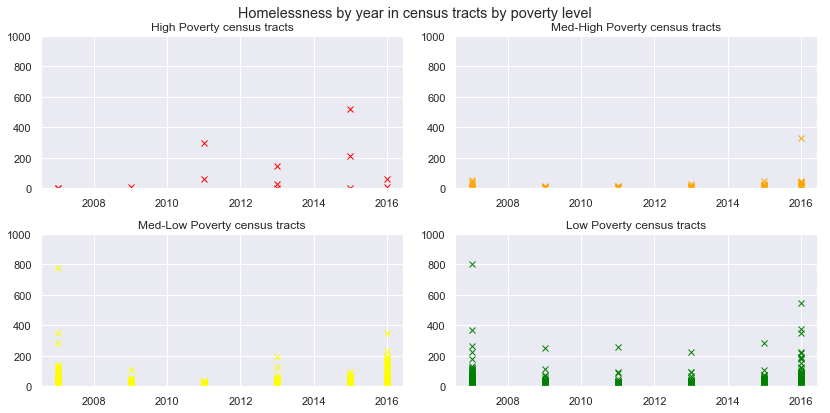

In [101]:
plt.subplot(2, 2, 1)
plt.plot(highpov['Year'], highpov['totalUnshelteredPeopleCount'], 'x', color='red')
plt.ylim(0,1000)
plt.title('High Poverty census tracts')

plt.subplot(2, 2, 2)
plt.plot(medhighpov['Year'], medhighpov['totalUnshelteredPeopleCount'],'x', color='orange')
plt.ylim(0,1000)
plt.title('Med-High Poverty census tracts')

plt.subplot(2, 2, 3)
plt.plot(medlowpov['Year'], medlowpov['totalUnshelteredPeopleCount'],'x', color='yellow')
plt.ylim(0,1000)
plt.title('Med-Low Poverty census tracts')

plt.subplot(2, 2, 4)
plt.plot(lowpov['Year'], lowpov['totalUnshelteredPeopleCount'],'x', color='green')
plt.ylim(0,1000)
plt.title('Low Poverty census tracts')

plt.suptitle('Homelessness by year in census tracts by poverty level')
plt.tight_layout(pad=2.0, w_pad=1.0, h_pad=1.0)

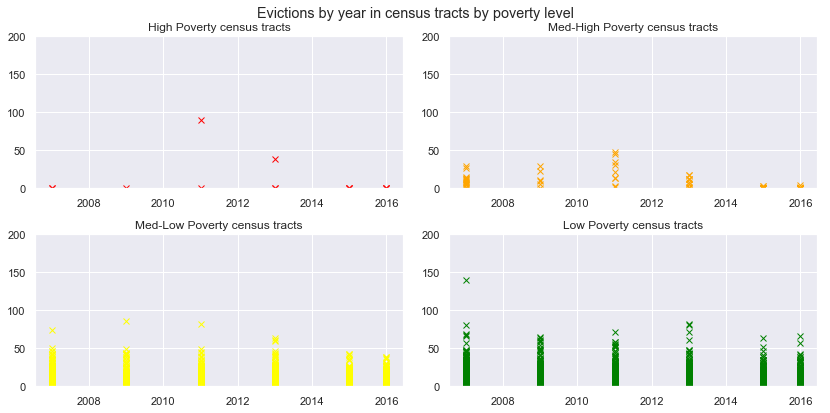

In [103]:
plt.subplot(2, 2, 1)
plt.plot(highpov['Year'], highpov['evictions'], 'x', color='red')
plt.ylim(0,200)
plt.title('High Poverty census tracts')

plt.subplot(2, 2, 2)
plt.plot(medhighpov['Year'], medhighpov['evictions'],'x', color='orange')
plt.ylim(0,200)
plt.title('Med-High Poverty census tracts')

plt.subplot(2, 2, 3)
plt.plot(medlowpov['Year'], medlowpov['evictions'],'x', color='yellow')
plt.ylim(0,200)
plt.title('Med-Low Poverty census tracts')

plt.subplot(2, 2, 4)
plt.plot(lowpov['Year'], lowpov['evictions'],'x', color='green')
plt.ylim(0,200)
plt.title('Low Poverty census tracts')

plt.suptitle('Evictions by year in census tracts by poverty level')
plt.tight_layout(pad=2.0, w_pad=1.0, h_pad=1.0)

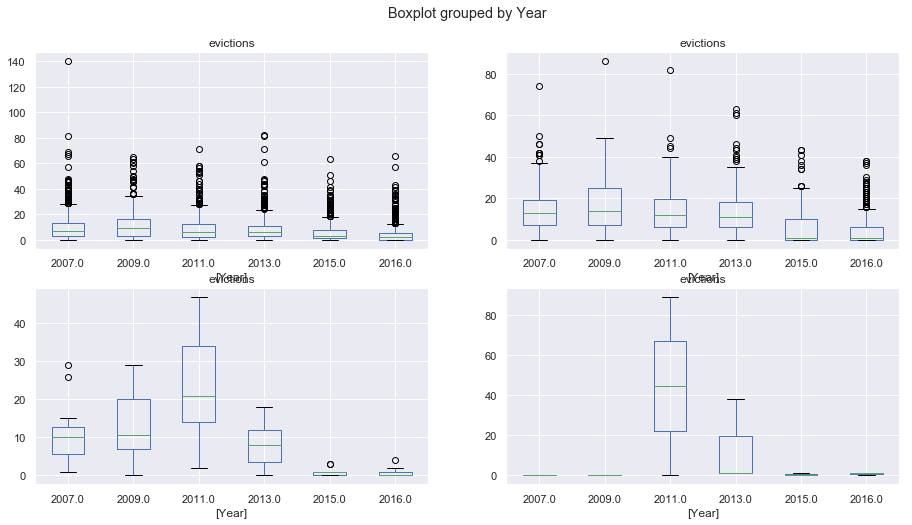

In [126]:
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax1.set_title("Low Poverty Rate (<25%)")
ax2 = fig.add_subplot(222)
ax2.set_title("Med-Low Poverty Rate (25-50%)")
ax3 = fig.add_subplot(223)
ax3.set_title("Med-High Poverty Rate (50-75%)")
ax4 = fig.add_subplot(224)
ax4.set_title("High Poverty Rate (>75%)")

lowpov.boxplot(column='evictions',by=['Year'], ax=ax1)
medlowpov.boxplot(column='evictions',by=['Year'], ax=ax2)
medhighpov.boxplot(column='evictions',by=['Year'], ax=ax3)
highpov.boxplot(column='evictions',by=['Year'], ax=ax4)


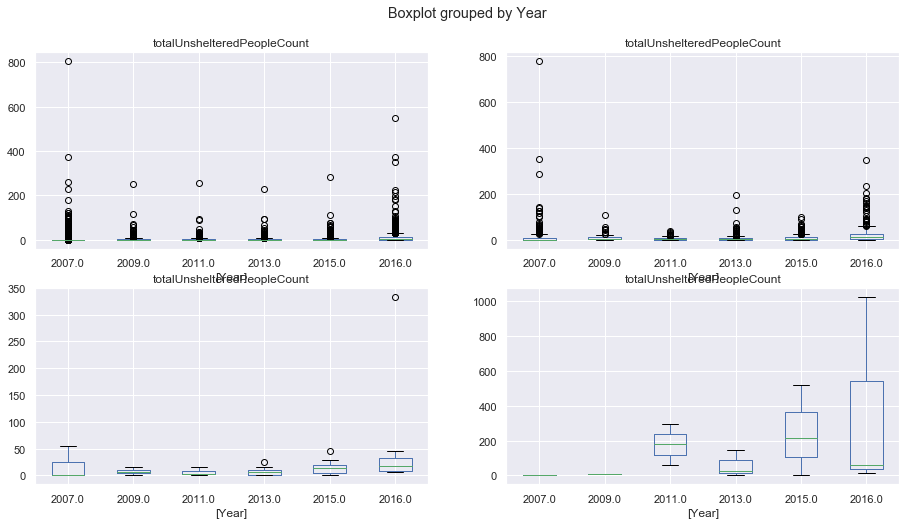

In [127]:
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax1.set_title("Low Poverty Rate (<25%)")
ax2 = fig.add_subplot(222)
ax2.set_title("Med-Low Poverty Rate (25-50%)")
ax3 = fig.add_subplot(223)
ax3.set_title("Med-High Poverty Rate (50-75%)")
ax4 = fig.add_subplot(224)
ax4.set_title("High Poverty Rate (>75%)")
lowpov.boxplot(column='totalUnshelteredPeopleCount',by=['Year'], ax=ax1)
medlowpov.boxplot(column='totalUnshelteredPeopleCount',by=['Year'], ax=ax2)
medhighpov.boxplot(column='totalUnshelteredPeopleCount',by=['Year'], ax=ax3)
highpov.boxplot(column='totalUnshelteredPeopleCount',by=['Year'], ax=ax4)


In [118]:
data2007 = EH_narm[EH_narm['Year'] == 2007] 
data2009 = EH_narm[EH_narm['Year'] == 2009]
data2011 = EH_narm[EH_narm['Year'] == 2011]
data2013 = EH_narm[EH_narm['Year'] == 2013]
data2015 = EH_narm[EH_narm['Year'] == 2015]
data2016 = EH_narm[EH_narm['Year'] == 2016]

## Group by Percentage of Renters in Tract
<p>potentially less confusing than poverty rate because some areas may have more subsidized housing</p>

In [130]:
#create new categorical data column for the percentage of renter occupied homes by tract
EH_narm['pctrenter_group'] = pd.cut(EH_narm['pct-renter-occupied'],bins=[0,33.3,66.6,100], labels=['low','med','high'])

/Users/sgd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [176]:
EH_narm['pctrenter_group'].head()
lowrenters = EH_narm[EH_narm['pctrenter_group'] == "low"] 
medrenters = EH_narm[EH_narm['pctrenter_group'] == "med"] 
highrenters = EH_narm[EH_narm['pctrenter_group'] == "high"]

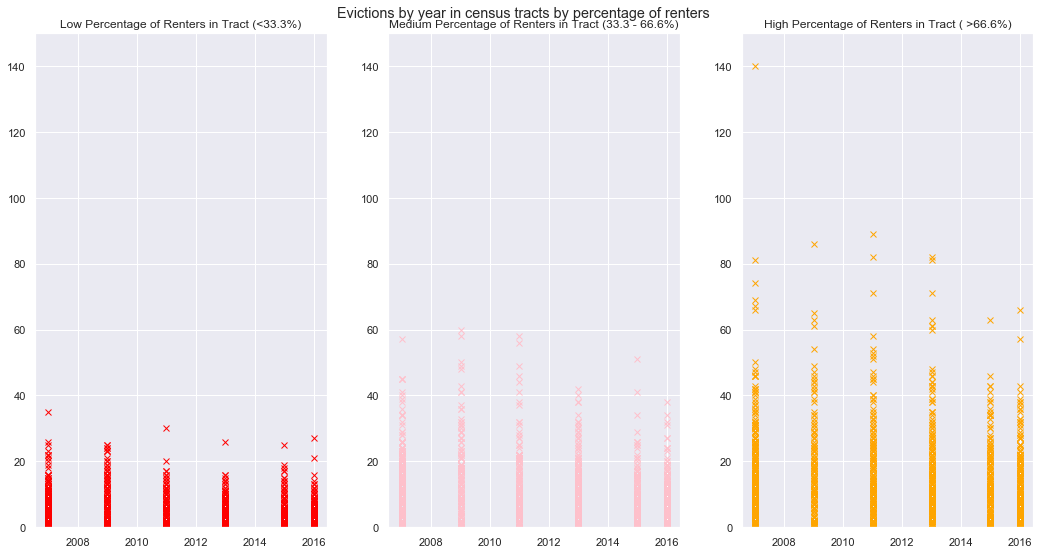

In [144]:
plt.subplot(1,3,1)
plt.plot(lowrenters['Year'], lowrenters['evictions'], 'x', color='red')
plt.ylim(0,150)
plt.title('Low Percentage of Renters in Tract (<33.3%)')
plt.subplot(1,3,2)
plt.plot(medrenters['Year'], medrenters['evictions'], 'x', color='pink')
plt.ylim(0,150)
plt.title('Medium Percentage of Renters in Tract (33.3 - 66.6%)')
plt.subplot(1,3,3)
plt.plot(highrenters['Year'], highrenters['evictions'], 'x', color='orange')
plt.ylim(0,150)
plt.title('High Percentage of Renters in Tract ( >66.6%)')


plt.suptitle('Evictions by year in census tracts by percentage of renters')
plt.tight_layout(pad=2.0, w_pad=1.0, h_pad=1.0)


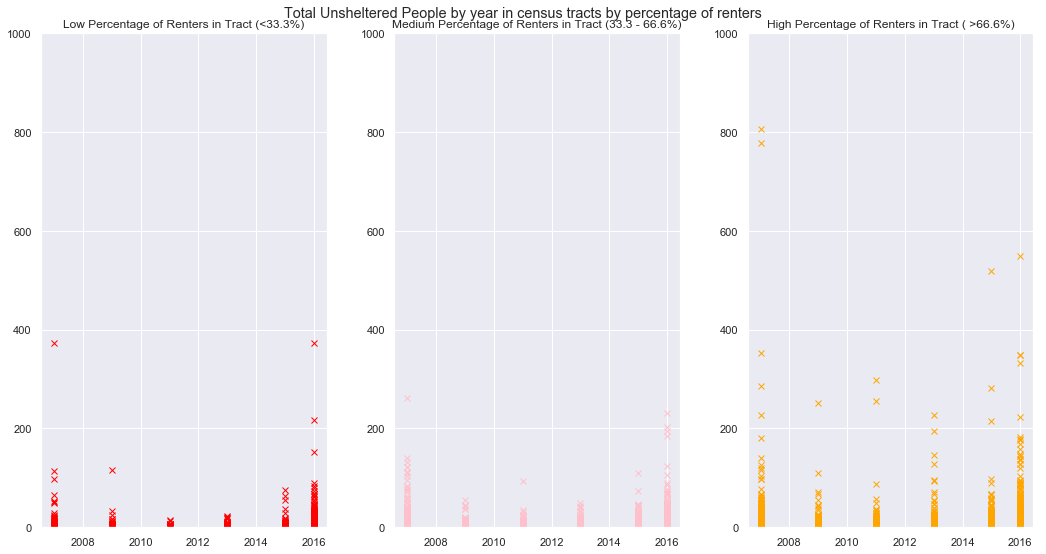

In [146]:
plt.subplot(1,3,1)
plt.plot(lowrenters['Year'], lowrenters['totalUnshelteredPeopleCount'], 'x', color='red')
plt.ylim(0,1000)
plt.title('Low Percentage of Renters in Tract (<33.3%)')
plt.subplot(1,3,2)
plt.plot(medrenters['Year'], medrenters['totalUnshelteredPeopleCount'], 'x', color='pink')
plt.ylim(0,1000)
plt.title('Medium Percentage of Renters in Tract (33.3 - 66.6%)')
plt.subplot(1,3,3)
plt.plot(highrenters['Year'], highrenters['totalUnshelteredPeopleCount'], 'x', color='orange')
plt.ylim(0,1000)
plt.title('High Percentage of Renters in Tract ( >66.6%)')


plt.suptitle('Total Unsheltered People by year in census tracts by percentage of renters')
plt.tight_layout(pad=2.0, w_pad=1.0, h_pad=1.0)

/Users/sgd/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


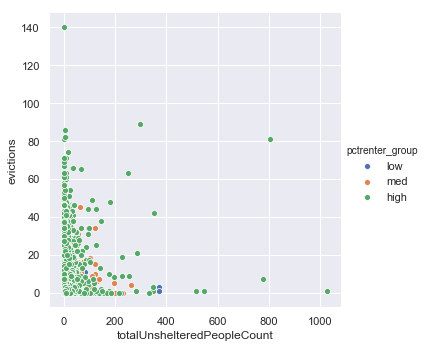

In [151]:
sns.pairplot(x_vars=["totalUnshelteredPeopleCount"], y_vars=["evictions"], data=EH_narm, hue='pctrenter_group', size=5)

## Strategy Change: work with eviction rate and Homelessness percentage

<p>re-try with eviction-rate and percentage of homeless by tract as # homeless / population * 100</p>
<p>Also start puttinng what is to be predicted (homelessness) on y axis</p>

In [160]:
EH_narm['homeless_rate'] = (EH_narm['totalUnshelteredPeopleCount']/EH_narm['population'])*100

EH_narm[['totalUnshelteredPeopleCount', 'population','homeless_rate']][0:10]

/Users/sgd/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,totalUnshelteredPeopleCount,population,homeless_rate
0,0.0,4973.0,0.000000
1,4.0,4824.0,0.082919
2,0.0,4824.0,0.000000
3,6.0,4824.0,0.124378
13,0.0,6965.0,0.000000
14,9.0,5882.0,0.153009
15,6.0,5882.0,0.102006
16,19.0,5882.0,0.323019
20,2.0,3466.0,0.057703
21,2.0,2902.0,0.068918


Text(0.5, 1.0, 'Eviction Rate vs. Homelessness Rate by Census Tract, 2007 - 2016')

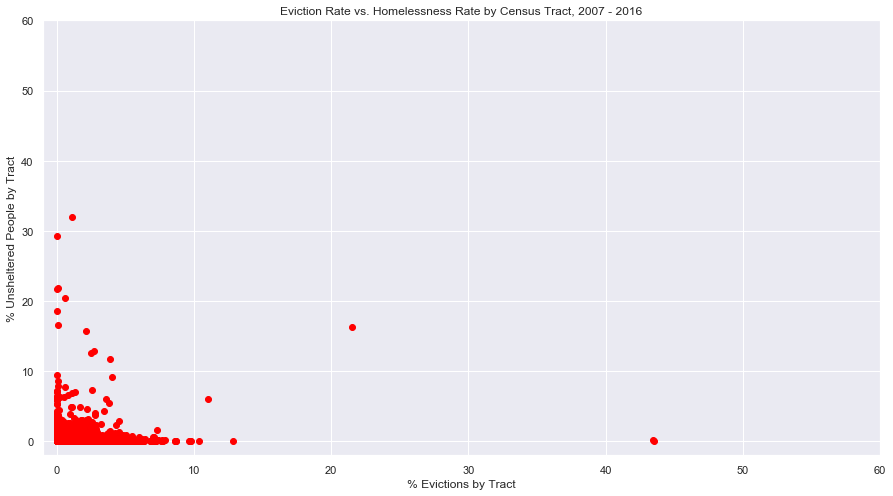

In [175]:
plt.plot(EH_narm['eviction-rate'], EH_narm['homeless_rate'],'o', color='red')
plt.xlim(-1,60)
plt.xlabel('% Evictions by Tract')
plt.ylim(-2,60)
plt.ylabel('% Unsheltered People by Tract')
plt.title('Eviction Rate vs. Homelessness Rate by Census Tract, 2007 - 2016')

Text(0.5, 0.98, 'Homelessness Rate by Percentage of Renters per Tract')

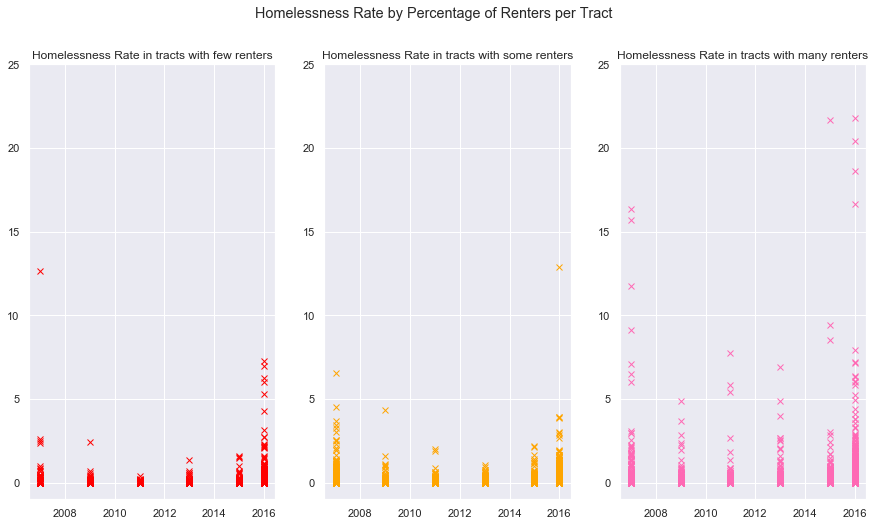

In [196]:
plt.subplot(1,3,1)
plt.plot(lowrenters['Year'], lowrenters['homeless_rate'], 'x', color='red')
plt.ylim(-1,25)
plt.title('Homelessness Rate in tracts with few renters')
plt.subplot(1,3,2)
plt.plot(medrenters['Year'], medrenters['homeless_rate'], 'x', color='orange')
plt.ylim(-1,25)
plt.title('Homelessness Rate in tracts with some renters')
plt.subplot(1,3,3)
plt.plot(highrenters['Year'], highrenters['homeless_rate'], 'x', color='hotpink')
plt.ylim(-1,25)
plt.title('Homelessness Rate in tracts with many renters')

plt.suptitle('Homelessness Rate by Percentage of Renters per Tract')

(-1, 5)

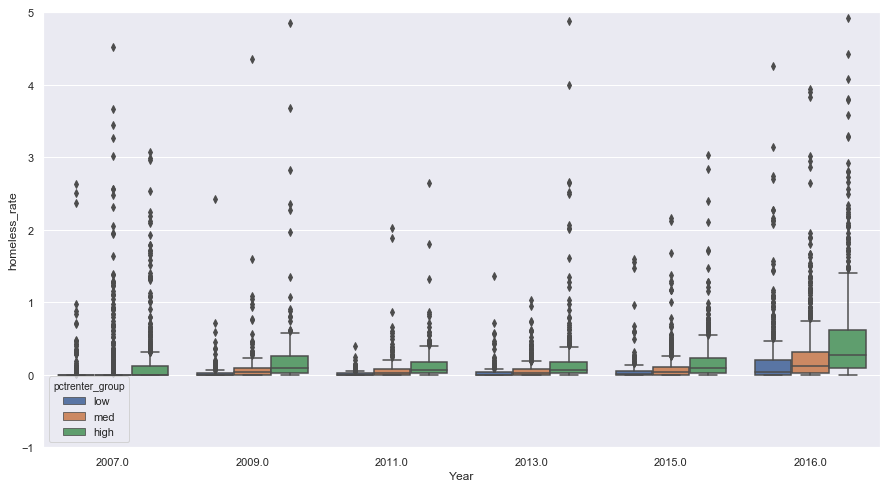

In [185]:
sns.boxplot(x="Year", hue="pctrenter_group", y="homeless_rate", data=EH_narm)
plt.ylim(-1, 5)

(-1, 10)

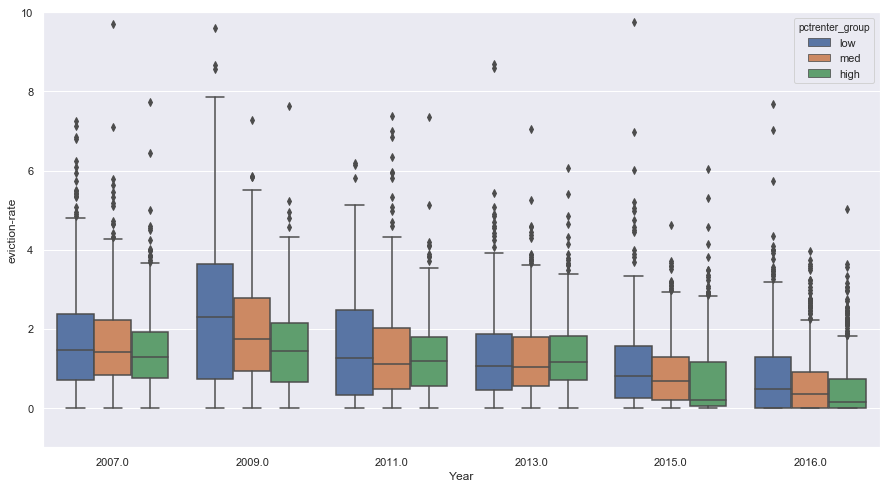

In [191]:
sns.boxplot(x="Year", hue="pctrenter_group", y="eviction-rate", data=EH_narm)
plt.ylim(-1, 10)

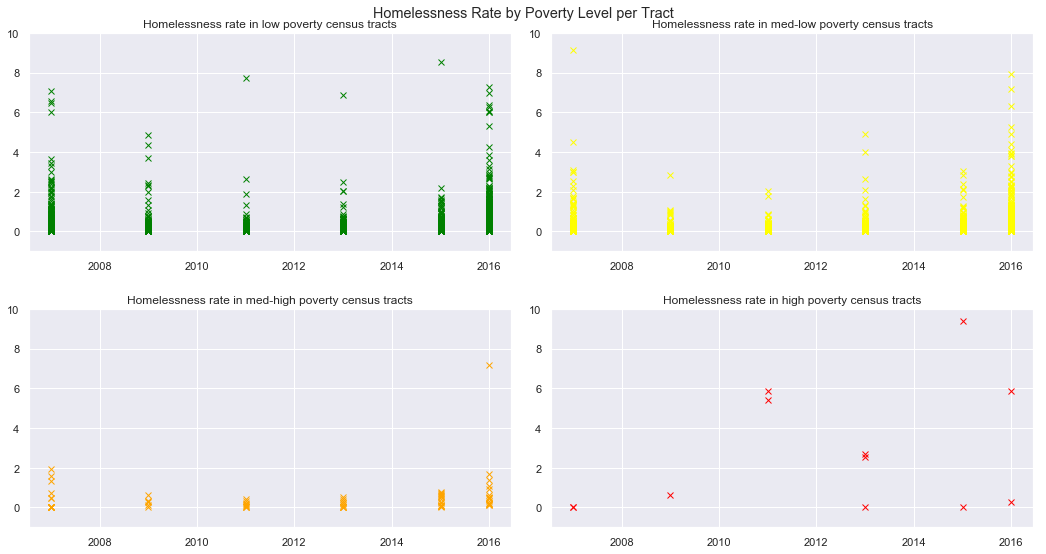

In [201]:
plt.subplot(2, 2, 4)
plt.plot(highpov['Year'], highpov['homeless_rate'], 'x', color='red')
plt.ylim(-1,10)
plt.title('Homelessness rate in high poverty census tracts')

plt.subplot(2, 2, 3)
plt.plot(medhighpov['Year'], medhighpov['homeless_rate'],'x', color='orange')
plt.ylim(-1,10)
plt.title('Homelessness rate in med-high poverty census tracts')

plt.subplot(2, 2, 2)
plt.plot(medlowpov['Year'], medlowpov['homeless_rate'],'x', color='yellow')
plt.ylim(-1,10)
plt.title('Homelessness rate in med-low poverty census tracts')

plt.subplot(2, 2, 1)
plt.plot(lowpov['Year'], lowpov['homeless_rate'],'x', color='green')
plt.ylim(-1,10)
plt.title('Homelessness rate in low poverty census tracts')

plt.suptitle('Homelessness Rate by Poverty Level per Tract')
plt.tight_layout(pad=2.0, w_pad=1.0, h_pad=2.0)